# Movie Recommendation

>Ming Zhao <br>
>December 28, 2021

Recommendation systems become more and more important for ecommerce platforms. <br>

In this project, I use Alternating Least Squares (ALS) to predict movie ratings and apply item-based filtering to identify movie similarities using [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/) with the DataFram API. Additionally, I write functions to recommend movies to any given user and find similar movies for any given movie. <br>
 
**Step1. Data Loading and Exploration** <br>
Load the rating data; establish corresponding spark dataframes; check the basic information of the dataset. <br>

**Step2. Online Analytical Processing (OLAP)** [Spark SQL] <br>
Find the number of users, movies, rated movies; list unrated movies, movie genres, movies in each genre. <br>

**Step3. Data Preprocessing** <br>
Keep necessary columns; change the data type from string to numeric; separate the data to 80% training and 20% testing.

**Step4. Model Selection** [Spark ML] <br> 
Build the ALS model and tune the hyperparameter using 5-fold corss-validation by applying the optimal hyperparameters on the final model. <br>

**Step5. Model Evaluation** <br>
Evaluate the recommendation model by measuring the root mean square error of rating predictions on the testing set. <br>

**Step6. Model Application: Recommend Movies to Users** <br>
Recommend movies for any given users based on the ALS model. <br>

**Step7. Model Application: Find Similar Movies** <br>
Find similar movies for any given movies based on the item-based method. <br>

For the best ALS model, its hyperparameters are: maxIter=10, rank=15, regParam=0.1. The root mean squared error (RMSE) on the testing data is 0.88 and on the whole data is 0.61. <br>
<br>


In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.ui.port','4041').master("local[4]").getOrCreate()

22/02/02 04:37:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark.version

'3.2.1'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine as p9
import math
%matplotlib inline

In [4]:
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [5]:
#!pip install koalas
#import databricks.koalas as ks
#to_koalas()
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import pyspark.pandas as ps
#to_pandas_on_spark()

In [6]:
import warnings
warnings.filterwarnings("ignore") 

## 1. Data Loading and Exploration

### Data Loading

In [7]:
df_movies = spark.read.load("data/movies.csv", format='csv', header = True)
df_ratings = spark.read.load("data/ratings.csv", format='csv', header = True) 
df_links = spark.read.load("data/links.csv", format='csv', header = True) 
df_tags = spark.read.load("data/tags.csv", format='csv', header = True) 

### Data Exploration

In [8]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [9]:
df_ratings.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [10]:
df_links.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [11]:
df_tags.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [12]:
df_ratings.count()

100836

In [13]:
uniq_user_df = df_ratings.groupBy("userId").count()
uniq_user_df.show(5)

+------+-----+
|userId|count|
+------+-----+
|   296|   27|
|   467|   22|
|   125|  360|
|   451|   34|
|     7|  152|
+------+-----+
only showing top 5 rows



In [14]:
uniq_movie_df = df_ratings.groupBy("movieId").count()
uniq_movie_df.show(5)

+-------+-----+
|movieId|count|
+-------+-----+
|    296|  307|
|   1090|   63|
| 115713|   28|
|   3210|   42|
|  88140|   32|
+-------+-----+
only showing top 5 rows



In [15]:
temp1 = uniq_user_df.agg({"count":"min"}).collect()[0][0]
temp2 = uniq_movie_df.agg({"count":"min"}).collect()[0][0]
#temp1 = uniq_user_df.to_pandas_on_spark()["count"].min() 
#temp2 = uniq_movie_df.to_pandas_on_spark()["count"].min() 

In [16]:
print("For the users that rated movies and the movies that were rated:")
print("Minimum number of ratings per user is {}".format(temp1))
print("Minimum number of rarings per movie is {}".format(temp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of rarings per movie is 1


In [17]:
temp1 = uniq_movie_df.filter(uniq_movie_df["count"]=="1").count()
#temp1 = (uniq_movie_df.to_pandas_on_spark()["count"]==1).sum() 
temp2 = df_ratings.select("movieId").distinct().count()

In [18]:
print("{} out of {} movies were rated by one user".format(temp1, temp2))

3446 out of 9724 movies were rated by one user


## 2. OLAP

***What is OLAP?*** <br>
OLAP is an **Online Analytical Processing** system. The main focus of OLAP system is to **extract** and **analyze** large amounts of data with complex queries. This is designed for decision-making for knowledge workers. <br>

***What is OLTP?*** <br>
OLTP is an **Online Transaction Processing** system. The main focus of OLTP system is to record the current **Update**, **Insertion**, and **Deletion** while transaction. This is designed for day-to-day operations for end-users, such as ATM. <br>

***OLAP vs. OLTP*** <br>
OLAP and OLTP both are the online processing systems. The main difference between the two systems is analytical vs. transactional.  <br>
OLAP is optimized for conducting complex data analysis. OLTP is optimized for managing transaction-oriented modification.  <br>

[Comparison Chart](https://techdifferences.com/difference-between-oltp-and-olap.html)


***ETL*** <br>
ETL is the force that joins OLTP and OLAP. The data from one or more OLTP databases is ingested into OLAP systems through a process called **Extraction, Transform, Load**. With an ETL tool, data can be collected from several sources and sent to a destination, such as an OLAP data warehouse, where it is queried by analytics for insights.  <br>
More generally, ETL is the process data engineers use to extract data from different sources, transform the data into a usable and trusted resource, and load that data into the system end-users can access and make use of. <br>

***ETL vs. Data Pipeline*** <br>
ETL is usually a sub-process. Depending on the nature of the pipeline, ETL may be automated or may not be included at all. On the other hand, a data pipeline is broader in that it is the entire process involved in transporting data from one location to another.


### Spark SQL

In [19]:
df_movies.createOrReplaceTempView("movies")
df_ratings.createOrReplaceTempView("ratings")
df_links.createOrReplaceTempView("links")
df_tags.createOrReplaceTempView("tags")

**(1). The Number of Users**

In [20]:
q1_result = spark.sql("SELECT count(distinct userId) AS number_of_users \
                       FROM ratings")
q1_result.show()

+---------------+
|number_of_users|
+---------------+
|            610|
+---------------+



**(2). The Number of Movies**

In [21]:
q2_result = spark.sql("SELECT count(movieId) AS number_of_movies \
                       FROM movies")
q2_result.show()

+----------------+
|number_of_movies|
+----------------+
|            9742|
+----------------+



**(3). The Number of Rated Movies; List Unrated Movies**

In [22]:
q3_result1 = spark.sql("SELECT count(distinct movieId) AS number_of_rated_movies \
                        FROM ratings")
# q3_result1=spark.sql("SELECT count(movieId) AS number_of_rated_moives \
#                       FROM movies WHERE movieID IN \
#                       (SELECT movieId FROM ratings)")
q3_result1.show()

+----------------------+
|number_of_rated_movies|
+----------------------+
|                  9724|
+----------------------+



In [23]:
q3_result2 = spark.sql("SELECT movieId, title \
                        FROM movies WHERE movieId NOT IN \
                        (SELECT movieID FROM ratings)")
q3_result2.show()

+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|   1076|Innocents, The (1...|
|   2939|      Niagara (1953)|
|   3338|For All Mankind (...|
|   3456|Color of Paradise...|
|   4194|I Know Where I'm ...|
|   5721|  Chosen, The (1981)|
|   6668|Road Home, The (W...|
|   6849|      Scrooge (1970)|
|   7020|        Proof (1991)|
|   7792|Parallax View, Th...|
|   8765|This Gun for Hire...|
|  25855|Roaring Twenties,...|
|  26085|Mutiny on the Bou...|
|  30892|In the Realms of ...|
|  32160|Twentieth Century...|
|  32371|Call Northside 77...|
|  34482|Browning Version,...|
|  85565|  Chalet Girl (2011)|
+-------+--------------------+



**(4). List Movie Genres**

In [24]:
q4_result = spark.sql("SELECT distinct EXPLODE(SPLIT(genres,'[|]')) AS genres \
                       FROM movies \
                       ORDER by 1")
q4_result.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



**(5). Movies for Each Genre**

In [25]:
q5_result1 = spark.sql("SELECT genres, count(movieID) AS number_of_movies \
                        FROM (SELECT distinct EXPLODE(SPLIT(genres,'[|]')) AS genres, movieId FROM movies) \
                        GROUP by 1 ORDER by 2 DESC")
q5_result1.show()

+------------------+----------------+
|            genres|number_of_movies|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [26]:
q5_result2 = spark.sql("SELECT genres, concat_ws(',', collect_set(title)) AS list_of_movies \
                        FROM (SELECT distinct EXPLODE(SPLIT(genres,'[|]')) AS genres, title FROM movies) \
                        GROUP by 1")
q5_result2.show()

+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

## 3. Data Preprocessing

In [27]:
df_ratings.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [28]:
# drop unnecessary columns
movie_ratings = df_ratings.drop("timestamp")

In [29]:
movie_ratings.dtypes

[('userId', 'string'), ('movieId', 'string'), ('rating', 'string')]

In [30]:
# convert data type
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [31]:
movie_ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows



In [32]:
hist_rating = movie_ratings.select("rating").groupBy("rating").count().toPandas()

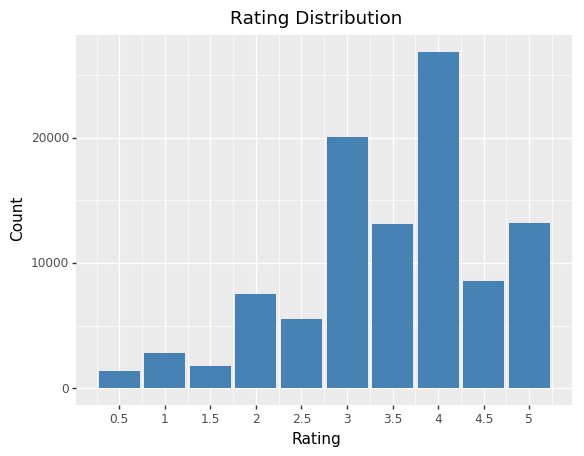

<ggplot: (8770968705221)>

In [33]:
gg = p9.ggplot(hist_rating)
gg += p9.aes(x='rating', y='count')
gg += p9.geom_bar(stat="identity", fill="steelblue")
gg += p9.labels.ggtitle('Rating Distribution')
gg += p9.xlab('Rating') + p9.ylab('Count')
gg += p9.scale_x_continuous(breaks=np.arange(0,6,0.5))
gg

In [34]:
# create training and testing sets
(train, test) = movie_ratings.randomSplit([0.8,0.2])

## 4. Model Selection

### Spark ML - ALS

Pipeline components: <br>
***Transformers*** <br>
A Transformer includes feature transformers and learned models. Technically, a Transformer implements a method transform(), which **converts one DataFrame into another**, generally by appending one or more columns.<br>
***Estimators*** <br>
An Estimator involves the concept of a learning algorithm or any algorithm that fits or trains on data. Technically, an Estimator implements a method fit(), which **accepts a DataFrame and produces a Model on it**.

***Explicit vs. Implicit Feedback***

The standard approach to matrix factorization-based collaborative filtering treats the entries in the user-item matrix as explicit preferences given by the user to the item, for example, users giving ratings to movies. <br>

It is common in many real-world use cases to only have access to implicit feedback (e.g. views, clicks, purchases, likes, shares, etc). Essentially, instead of trying to model the matrix of ratings directly, this approach treats the data as numbers representing the strength in observations of user actions. Those numbers are then related to the level of confidence in observed user preferences, rather than explicit ratings given to items. The model then tries to find latent factors that can be used to predict the expected preference of a user for an item. <br>

[Implicit Collaborative Filtering](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe)

[Alpha in Implicit Collaborative Filtering](http://yifanhu.net/PUB/cf.pdf)

***Cold-start strategy*** <br>

It is common to encounter users and/or items in the test dataset that were not present during training the model. This typically occurs in two scenarios: <br>

* In production, for new users or items that have no rating history and on which the model has not been trained (this is the “cold start problem”). <br>

* During cross-validation, the data is split between training and evaluation sets. It is actually common to encounter users and/or items in the evaluation set that are not in the training set

By default, Spark assigns NaN predictions during transform() when a user and/or item factor is not present in the model. This can be useful in a production system, since it indicates a new user or item, and so the system can make a decision on some fallback to use as the prediction. <br>

However, this is undesirable during cross-validation, since any NaN predicted values will result in NaN results for the evaluation metric. This makes model selection impossible. <br>

Spark allows users to set the coldStartStrategy parameter to “drop” in order to drop any rows in the DataFrame of predictions that contain NaN values. The evaluation metric will then be computed over the non-NaN data and will be valid. <br>


In [35]:
# create ALS model

# rank: the number of latent factors in the model (defaults to 10)
# maxIter: the maximum number of iterations to run (defaults to 10)
# regParam: the regularization parameter in ALS (defaults to 1.0)
# implicitPrefs: whether to use the explicit feedback ALS variant or
#                or one adapted for implicit feedback data (defaults
#                to false which means using explicit feedback)
# alpha: paramether applicable to the implicit feedback variant of ALS
#        that governs the baseline confidence in preference observations
#        (defaults to 1.0)

als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop",
          seed=1991)

In [36]:
# tune model using ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(als.maxIter, [1, 5, 10])
             .addGrid(als.rank, [5, 10, 15])
             .addGrid(als.regParam, [0.01, 0.1, 0.5, 1])
             .build())

In [37]:
# define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="rating",
                                predictionCol="prediction")

In [38]:
# build cross validation
cv = CrossValidator(estimator=als, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=evaluator,
                    numFolds=5, seed=1991)

In [39]:
# fit als model to training data
cv_model = cv.fit(train)

In [40]:
# extract best model from the tuning exercise using ParamGridBuilder
best_model = cv_model.bestModel

## 5. Model Evaluation 

In [41]:
# generate and evaluate predictions using RMSE
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)

In [43]:
predictions.show(5)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   597|    471|   2.0| 4.2227035|
|   597|   2366|   5.0| 3.9531033|
|   108|   1959|   5.0| 3.7222388|
|    34|   3997|   2.0| 0.5044399|
|   368|   2366|   4.0| 3.1997702|
+------+-------+------+----------+
only showing top 5 rows



In [44]:
predictions_alldata = best_model.transform(movie_ratings)
rmse = evaluator.evaluate(predictions_alldata)
print("RMSE = " + str(rmse))

RMSE = 0.6105223084059328


In [45]:
predictions_alldata.createOrReplaceTempView("alldata")

In [46]:
spark.sql("SELECT * FROM alldata").show(5)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5| 3.3933322|
|   137|   1580|   3.5|  3.262342|
|   580|   1580|   4.0|  3.676123|
|   580|   3175|   2.5| 3.5508008|
|   580|  44022|   3.5| 3.2996948|
+------+-------+------+----------+
only showing top 5 rows



In [47]:
spark.sql("SELECT * FROM movies").show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [48]:
spark.sql("SELECT * FROM movies \
           JOIN alldata ON \
           movies.movieId=alldata.movieId").show(5)

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|   1088|Dirty Dancing (1987)|Drama|Musical|Rom...|   463|   1088|   3.5| 3.3933322|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   137|   1580|   3.5|  3.262342|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   580|   1580|   4.0|  3.676123|
|   3175| Galaxy Quest (1999)|Adventure|Comedy|...|   580|   3175|   2.5| 3.5508008|
|  44022|Ice Age 2: The Me...|Adventure|Animati...|   580|  44022|   3.5| 3.2996948|
+-------+--------------------+--------------------+------+-------+------+----------+
only showing top 5 rows



## 6. Model Application: Recommend Movies to Users 

Users with ID 575 <br>
Users with ID 232 <br>

In [58]:
# generate top 10 movie recommendations for each user
userRecs = best_model.recommendForAllUsers(10)

In [59]:
userRecs.show(5)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     1|[{5915, 5.653569}...|
|     3|[{6835, 4.902745}...|
|     5|[{2693, 4.942243}...|
|     6|[{3404, 4.878174}...|
|     9|[{1232, 4.9389243...|
+------+--------------------+
only showing top 5 rows



In [51]:
# generate top 10 user recommendations for each movie
movieRecs = best_model.recommendForAllItems(10)
movieRecs.show(5)

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|      1|[{43, 5.269853}, ...|
|     12|[{558, 4.2132874}...|
|     13|[{43, 4.1564035},...|
|     22|[{53, 4.559867}, ...|
|     26|[{35, 4.4933414},...|
+-------+--------------------+
only showing top 5 rows



In [52]:
df_movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [53]:
def movieRecommendation(top_k, user_id):
    recs_list = []
    userRecs = best_model.recommendForAllUsers(top_k)
    userIdRecs_ks = userRecs.filter(userRecs.userId==user_id).to_pandas_on_spark()
    userIdRecs_list = userIdRecs_ks["recommendations"].to_list()[0]
    for recs in userIdRecs_list:
        recs_list.append(str(recs[0]))
    return df_movies.filter(df_movies.movieId.isin(recs_list)).to_pandas_on_spark()

In [54]:
print("The 5 movies recommended for user with id '575' are as follows:")
movieRecommendation(top_k=10, user_id=575)

The 5 movies recommended for user with id '575' are as follows:


,movieId,title,genres
0,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1,319,Shallow Grave (1994),Comedy|Drama|Thriller
2,858,"Godfather, The (1972)",Crime|Drama
3,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
4,1250,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War
5,5490,The Big Bus (1976),Action|Comedy
6,5915,Victory (a.k.a. Escape to Victory) (1981),Action|Drama|War
7,6818,Come and See (Idi i smotri) (1985),Drama|War
8,51931,Reign Over Me (2007),Drama
9,132333,Seve (2014),Documentary|Drama


In [55]:
print("The 10 movies recommended for user with id '232' are as follows:")
movieRecommendation(top_k=10, user_id=232)

The 10 movies recommended for user with id '232' are as follows:


,movieId,title,genres
0,51931,Reign Over Me (2007),Drama
1,86781,Incendies (2010),Drama|Mystery|War
2,104780,"Mystery of the Third Planet, The (Tayna tretey...",Adventure|Animation|Sci-Fi
3,130970,George Carlin: Life Is Worth Losing (2005),Comedy
4,142020,Oscar (1967),Comedy
5,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed)
6,147300,Adventures Of Sherlock Holmes And Dr. Watson: ...,Crime|Mystery
7,147330,Sherlock Holmes and Dr. Watson: Acquaintance (...,Crime
8,159811,The Bremen Town Musicians (1969),Animation|Drama|Fantasy
9,175431,Bobik Visiting Barbos (1977),Animation|Comedy


## 7. Model Application: Find Similar Movies 

Movies with ID 463 <br>
Movies with ID 471 <br>

In [60]:
itemFactors=best_model.itemFactors

In [61]:
itemFactors.show(5, False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                                                                                                 |
+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|10 |[-0.6457395, -0.22321345, -0.6062841, 0.9525815, -0.19517425, 0.05154608, -0.36017135, 0.27226412, 0.8612797, -0.67159164, -0.5995275, -0.16090529, -0.69174737, 0.45058945, -0.39000058]|
|20 |[-0.057551075, -0.92649025, -0.6774009, 0.39859068, 0.28499115, -0.13840652, 0.18075271, 0.8649549, 0.45194462, -0.9055602, -0.22489735, -0.04528264, -0.31150037, 0.7444006, 0.12156328]|
|30 |[0.06797546, -0.25225285, -0.167246

In [62]:
def similarMovies(top_k, movie_id, matrix):
    try:
        movieFeature=itemFactors.filter(itemFactors.id==movie_id).to_pandas_on_spark()["features"].to_list()[0]
    except:
        return "There is no movie with id " + str(movie_id)
    
    if matrix=="cosine_similarity":
        similarMovie=pd.DataFrame(columns=("movieId", "cosine_similarity"))
        for id, feature in itemFactors.to_pandas_on_spark().to_numpy():
            """
            Method 1: cosine similarity
            The larger the cosine value, the smaller the two-feature vectors' angle, the similar the movies
            This similarity only considers the direction
            e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered same
            """
            cs=np.dot(movieFeature, feature)/(np.linalg.norm(movieFeature)*np.linalg.norm(feature))
            
            similarMovie=similarMovie.append({"movieId": str(id), "cosine_similarity":cs}, ignore_index=True)
        similarMovie_top=similarMovie.sort_values(by=['cosine_similarity'],ascending = False)[1:(top_k+1)]
        joint=similarMovie_top.merge(df_movies.toPandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
    if matrix=="euclidean_distance":
        similarMovie=pd.DataFrame(columns=("movieId", "euclidean_distance"))
        for id, feature in itemFactors.to_pandas_on_spark().to_numpy():
            """
            Method 2: euclidean distance based similarity
            The smaller the euclidean distance between the factors, the similar the movies
            This similarity considers the actual strength
            e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered not similar enough
            """
            ed=np.linalg.norm(np.array(movieFeature)-np.array(feature))
            
            similarMovie=similarMovie.append({"movieId": str(id), "euclidean_distance":ed}, ignore_index=True)
        similarMovie_top=similarMovie.sort_values(by=['euclidean_distance'])[1:(top_k+1)]
        joint=similarMovie_top.merge(df_movies.toPandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
    return joint[['movieId','title','genres']]

In [63]:
similarMovies(10, 463, matrix="cosine_similarity")

'There is no movie with id 463'

In [64]:
similarMovies(10, 471, matrix="cosine_similarity")

,movieId,title,genres
0,1914,Smoke Signals (1998),Comedy|Drama
1,1643,"Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1...",Drama|Romance
2,14,Nixon (1995),Drama
3,7352,Wilbur Wants to Kill Himself (2002),Comedy|Drama|Romance
4,60293,"Wackness, The (2008)",Comedy|Drama|Romance
5,44889,Reefer Madness: The Movie Musical (2005),Comedy|Drama|Musical
6,3098,"Natural, The (1984)",Drama
7,7122,King of Hearts (1966),Comedy|Drama|War
8,34164,Happy Endings (2005),Comedy|Drama
9,902,Breakfast at Tiffany's (1961),Drama|Romance


In [65]:
similarMovies(10, 471, matrix="euclidean_distance")

,movieId,title,genres
0,1914,Smoke Signals (1998),Comedy|Drama
1,1643,"Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1...",Drama|Romance
2,14,Nixon (1995),Drama
3,60293,"Wackness, The (2008)",Comedy|Drama|Romance
4,44889,Reefer Madness: The Movie Musical (2005),Comedy|Drama|Musical
5,3098,"Natural, The (1984)",Drama
6,7122,King of Hearts (1966),Comedy|Drama|War
7,7352,Wilbur Wants to Kill Himself (2002),Comedy|Drama|Romance
8,902,Breakfast at Tiffany's (1961),Drama|Romance
9,1449,Waiting for Guffman (1996),Comedy
